In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

       Feature  Importance
3          TDS    0.429033
0    turbidity    0.293694
2  temperature    0.223725
1           pH    0.053549


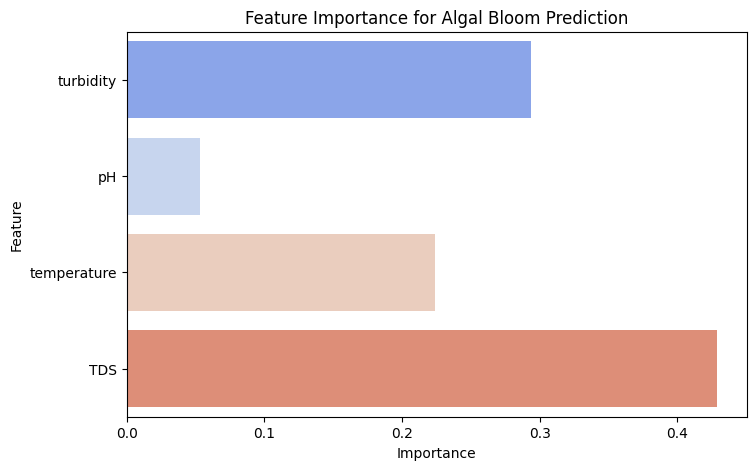

In [34]:
# Step 1: Load Sensor Data
data = pd.read_csv("balanced_algal_bloom_data.csv")  # Columns: turbidity, pH, temperature, TDS

# Step 2: Identify Key Drivers using Random Forest & CART
X = data[['turbidity', 'pH', 'temperature', 'TDS']]
y = data['Algal Bloom']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualization of Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='coolwarm')
plt.title("Feature Importance for Algal Bloom Prediction")
plt.show()

In [36]:
# Model Evaluation
y_pred_rf = rf_model.predict(X_test)
rf_scores = {
    "Model": "Random Forest",
    "R² Score": r2_score(y_test, y_pred_rf),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    "MAE": mean_absolute_error(y_test, y_pred_rf)
}
print(rf_scores)

{'Model': 'Random Forest', 'R² Score': 0.9999958809597363, 'RMSE': 0.001, 'MAE': 0.0001}


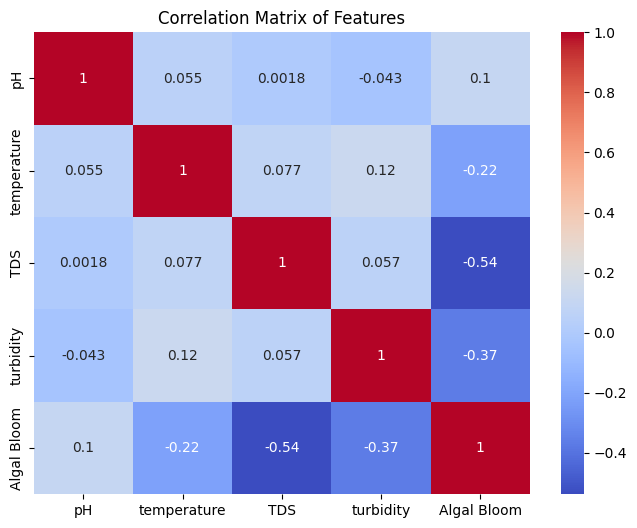

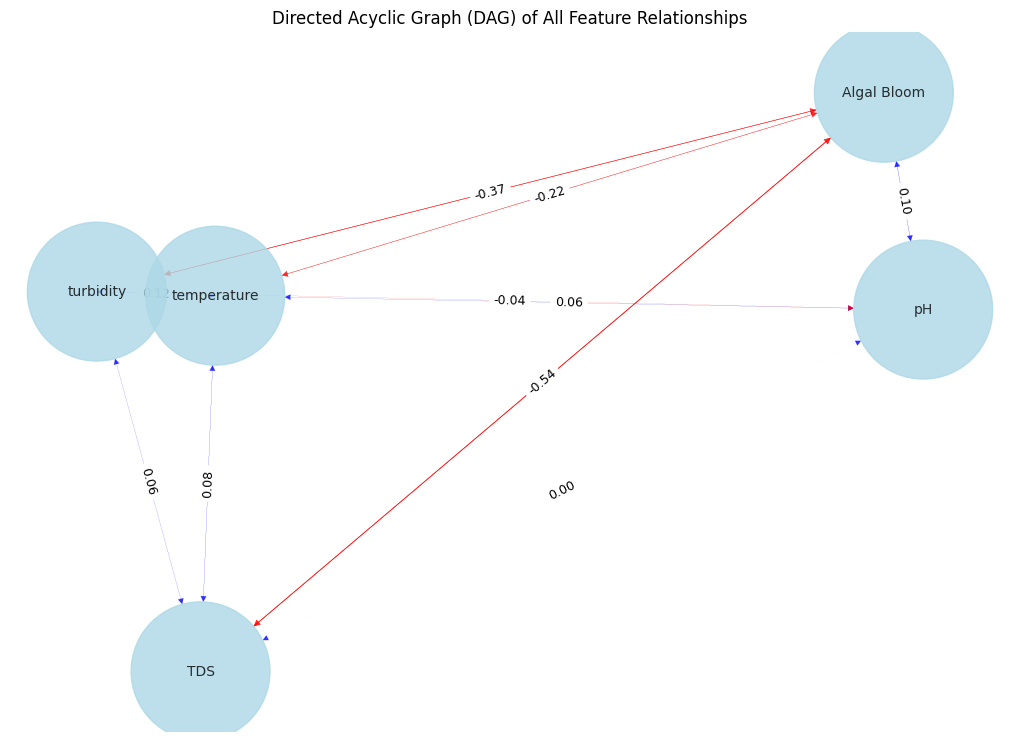

In [37]:
# Step 3: Directed Acyclic Graph (DAG) Visualization
corr_matrix = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

G = nx.DiGraph()
# Add edges for all variable relationships
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row:  # Avoid self-loops
            G.add_edge(row, col, weight=corr_matrix.loc[row, col])

# Node size based on degree centrality
node_size = [5000 * nx.degree_centrality(G)[node] for node in G.nodes()]

# Edge attributes: color (positive/negative) and width (correlation strength)
edge_weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
edge_colors = ['red' if G[u][v]['weight'] < 0 else 'blue' for u, v in G.edges()]

# Choose layout (spring_layout for better spacing)
pos = nx.spring_layout(G, seed=42)  

# Plot DAG with enhancements
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors,
        node_size=node_size, font_size=10, width=edge_weights, alpha=0.8)

# Add edge labels (correlation values)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Directed Acyclic Graph (DAG) of All Feature Relationships")
plt.show()

Epoch 1/35


C:\Users\yaswanth kolla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4792 - loss: 1.9699 - val_accuracy: 0.5850 - val_loss: 1.0047 - learning_rate: 2.0000e-04
Epoch 2/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5406 - loss: 1.2875 - val_accuracy: 0.5850 - val_loss: 0.7837 - learning_rate: 2.0000e-04
Epoch 3/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5849 - loss: 1.0009 - val_accuracy: 0.6300 - val_loss: 0.5755 - learning_rate: 2.0000e-04
Epoch 4/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5834 - loss: 0.8983 - val_accuracy: 0.7100 - val_loss: 0.4892 - learning_rate: 2.0000e-04
Epoch 5/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5959 - loss: 0.7743 - val_accuracy: 0.8850 - val_loss: 0.4295 - learning_rate: 2.0000e-04
Epoch 6/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6563 - loss: 0.6859 - val_accuracy: 0.8500 - val_loss: 0.3919 - learning_rate: 2.0000e-04
Epoch 7/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7442 - loss: 0.5354

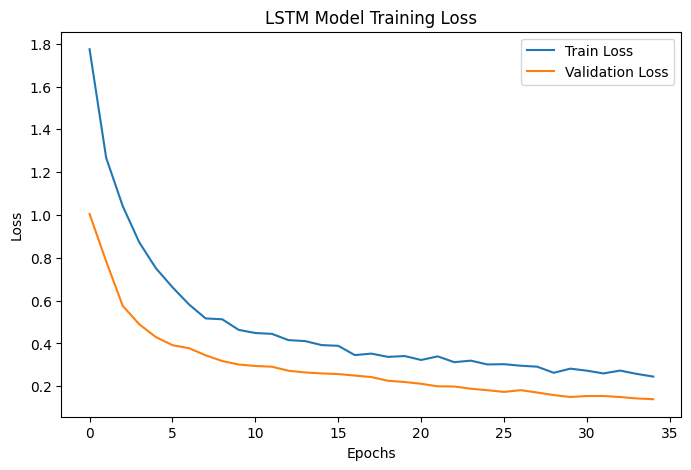

In [38]:

# Step 4: LSTM Model for Algae Bloom Prediction
X_lstm = data[['temperature', 'turbidity', 'pH', 'TDS']].values
y_lstm = data['Algal Bloom'].values  # No need to reshape if already a 1D array

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 2: Build the Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop if val_loss doesn't improve
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduce LR on plateaus
]

# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_test, y_test), batch_size=16, callbacks=callbacks)
# Step 6: Smooth Loss Graph with Moving Average
def smooth_curve(points, factor=0.5):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing to loss curves
train_loss_smooth = smooth_curve(history.history['loss'])
val_loss_smooth = smooth_curve(history.history['val_loss'])

# Step 5: Evaluate Model
y_pred_lstm = model.predict(X_test).flatten()
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)  # Convert sigmoid output to 0 or 1

# Compute metrics
lstm_scores = {
    "Model": "LSTM",
    "R² Score": r2_score(y_test, y_pred_lstm),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lstm)),
    "MAE": mean_absolute_error(y_test, y_pred_lstm)
}
print(lstm_scores)

# Step 6: Visualize Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [39]:
# Save model for deployment
model.save("algae_lstm_model.h5")

# Compare Evaluation Metrics
import pandas as pd
results_df = pd.DataFrame([rf_scores, lstm_scores])
print(results_df)

print("Model training completed and saved.")

           Model  R² Score      RMSE     MAE
0  Random Forest  0.999996  0.001000  0.0001
1           LSTM  0.794048  0.223607  0.0500
Model training completed and saved.
